In [1]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample


from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Create data frame of annotation info

In [3]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(1084, 13)
Int64Index([], dtype='int64')
(1084, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,533,5,low slug,46305.0,32714.904,0.368722,39977.724643,9966.541464,2.313672,9.578221,0.000271,37978.838411
1,1,533,5,low slug,149692.5,43037.465,0.306856,37931.297975,20543.321215,4.308415,22.308306,-0.000239,36034.733076
2,2,533,5,low slug,243157.5,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566
3,3,533,5,low slug,243270.0,63014.450,0.232295,32242.081971,21947.090189,5.325133,33.372614,-0.000671,30629.977872
4,4,533,5,low multi,295560.0,74933.164,0.206291,17095.059221,11740.918797,5.372725,34.224633,-0.001093,16240.306260


In [4]:
annot_features_full = annot_features_full[annot_features_full['Annotation'] != 'noise']

In [5]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                             Animal                                                            Group                                              time_stamp                                                                                     power_sum                                                                                             spec_pur                                                                       spec_cent                                                                                                   spec_spread                                                                                                         spec_skew                                                                       spec_kurt                                                                              spec_slope                                                                       spec_roll                              \
                count        mean         std   min     25%    50%     75%    max  count        mean        std    min    25%    50%    75%    max  count      mean       std  min  25%  50%  75%  max      count           mean            std      min         25%        50%         75%       max     count           mean            std        min           25%          50%          75%        max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max       count           mean            std           min            25%            50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std        min        25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean           std   
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
bbc              16.0   81.875000   26.181100  21.0   76.25   84.5  101.75  107.0   16.0  551.125000   8.724487  534.0  543.0  554.0  559.0  559.0   16.0  4.437500  0.512348  4.0  4.0  4.0  5.0  5.0       16.0  222723.281250  161859.049561  13590.0  117303.750  196908.75  301685.625  535702.5      16.0  204078.307625  193322.116804  65204.582  118303.71000  157959.0050  179809.2375   872012.6     16.0  0.101816  0.046395  0.026119  0.085418  0.089934  0.118413  0.219365      16.0  31369.661776   3408.032166  25428.290261  29530.387395  31273.059220  33965.217581  36864.114756        16.0  154295.504440   45887.605222  82643.398891  124006.380527  157006.199597  171826.955013  272975.403907      16.0  4.301428  0.821950  3.272398  3.639845  4.074513  4.857638  5.614859      16.0  19.744209   8.720991  10.020710  12.778336  17.275809  25.393034  34.627316       16.0 -0.002649  0.000134 -0.002793 -0.002730 -0.002686 -0.002620 -0.002319      16.0  29801.178687   3237.630558   
high multi        5.0   60.800000   34.981424  10.0   53.00

In [6]:
#separate and save for later testing dataset
train_orig, test_orig = train_test_split(annot_features_full, test_size=0.3, random_state=1, stratify = annot_features_full.Annotation)

In [42]:
train_orig_maj = train_orig[train_orig['Annotation'] == 'rand_noise']
train_orig_min = train_orig[train_orig['Annotation'] != 'rand_noise']

train_orig_min_upsamples = resample(train_orig_min, replace=True, n_samples = len(train_orig_maj), random_state = 123)

train_orig_upsamples = pd.concat([train_orig_min_upsamples, train_orig_maj])

print(train_orig_upsamples.Annotation.value_counts())

train_orig_upsamples.head()

rand_noise    630
low slug      362
bbc           107
low multi      98
high slug      35
high multi     28
Name: Annotation, dtype: int64


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
89,89,554,4,low multi,455805.0,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517
28,28,535,5,low multi,22927.5,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713
67,67,542,4,low slug,378922.5,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470
96,96,555,4,low slug,260842.5,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800
56,56,535,5,high multi,442462.5,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329


In [8]:
groups = train_orig_upsamples['Unnamed: 0'].values
annot_labels_up = train_orig_upsamples['Annotation']
annot_labels_up.replace(regex={r'low slug': 1, 'high slug': 1, 'low multi': 1, 'high multi': 1, 'bbc': 1, 'noise': 0, 'rand_noise': 0}, inplace=True)

In [9]:
annot_features_up = train_orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
annot_features_up.head()

,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
89,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517
28,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713
67,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470
96,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800
56,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329


In [10]:
group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(annot_features_up, annot_labels_up, groups))

In [11]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

In [35]:
lr_cv = LogisticRegression(random_state=0)
rf_cv = RandomForestClassifier(max_depth=10, random_state=0)
svm_cv = svm.SVC()

In [14]:
y_pred_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(annot_labels_up, y_pred_lr)
conf_mat_lr

C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local

array([[469, 161],
       [136, 494]], dtype=int64)

In [15]:
y_pred_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(annot_labels_up, y_pred_rf)
conf_mat_rf

C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 

array([[606,  24],
       [242, 388]], dtype=int64)

In [37]:
y_pred_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
#y_pred_prob_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(annot_labels_up, y_pred_svm)
conf_mat_svm

C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid th

array([[536,  94],
       [128, 502]], dtype=int64)

In [18]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_lr))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_lr))

Sensitivity/Recall (TPR):  0.7841269841269841
Precision (PPV):  0.7541984732824427
Accuracy:  0.7642857142857142
F1: 0.7688715953307393


In [19]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_rf))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_rf))

Sensitivity/Recall (TPR):  0.6158730158730159
Precision (PPV):  0.941747572815534
Accuracy:  0.7888888888888889
F1: 0.744721689059501


In [21]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_svm))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_svm))

Sensitivity/Recall (TPR):  0.7968253968253968
Precision (PPV):  0.8408710217755444
Accuracy:  0.823015873015873
F1: 0.8182559087204564


In [24]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_rf[:,1]))

Logistic regression ROC_AUC:  0.8364550264550265
Random forest ROC_AUC:  0.9090388007054674


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

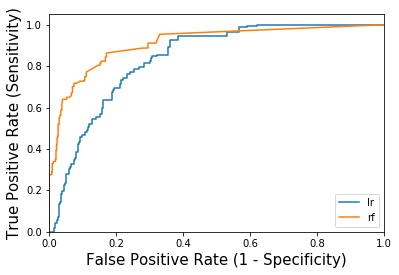

In [27]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(annot_labels_up, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(annot_labels_up, y_pred_prob_rf[:,1])
#fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(annot_labels_up, y_pred_prob[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

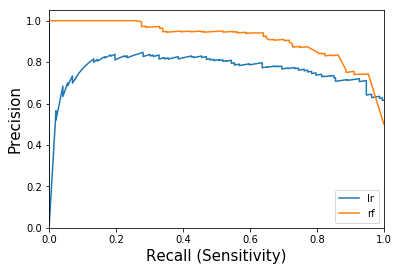

In [28]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_lr = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_rf = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_rf[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

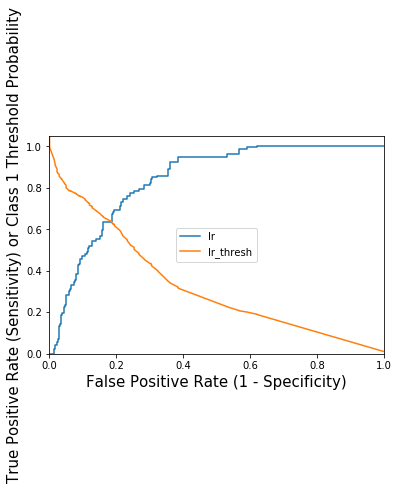

In [31]:
# plot LR and RF model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_lr,thresholds_lr, label="lr_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [44]:
train_orig_upsamples['pred_lr'] = y_pred_prob_lr[:,1]
train_orig_upsamples['pred_rf'] = y_pred_prob_rf[:,1]
train_orig_upsamples.head()

,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,pred_lr,pred_rf
89,89,554,4,low multi,455805.0,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517,0.763563,0.793550
28,28,535,5,low multi,22927.5,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713,0.756353,0.663796
67,67,542,4,low slug,378922.5,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470,0.315506,0.000000
96,96,555,4,low slug,260842.5,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800,0.787235,0.090323
56,56,535,5,high multi,442462.5,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329,0.617147,0.987273


In [46]:
train_orig_upsamples.groupby('Annotation')['pred_lr', 'pred_rf'].describe()

pred_lr                                                                       pred_rf                                                                      
             count      mean       std       min       25%       50%       75%       max   count      mean       std       min       25%       50%       75%       max
Annotation                                                                                                                                                            
bbc          107.0  0.789800  0.100548  0.595083  0.764301  0.801021  0.864593  0.931659   107.0  0.807403  0.216995  0.394512  0.589864  0.890783  0.989773  0.996083
high multi    28.0  0.514759  0.124671  0.341825  0.341825  0.545618  0.617147  0.623851    28.0  0.384343  0.373064  0.100000  0.100000  0.100000  0.540654  0.987273
high slug     35.0  0.587252  0.159388  0.187807  0.523594  0.661120  0.666424  0.741221    35.0  0.400164  0.281899  0.000000  0.195833  0.600000  0.600000  0.740188
low multi     98.0  0.712890  0.103243  0.479079  0.628706  0.759221  0.787941  0.821989    98.0  0.590411  0.319336  0.046667  0.190323  0.663796  0.880808  0.991882
low slug     362.0  0.627144  0.218770  0.200557  0.432595  0.710366  0.816573  0.906622   362.0  0.521559  0.312851  0.000000  0.205758  0.587223  0.757088  0.985464
rand_noise   630.0  0.326180  0.259053  0.009650  0.126859  0.240929  0.513857  0.996192   630.0  0.081176  0.168448  0.000000  0.000000  0.000000  0.100000  0.878477

In [47]:
y_pred_lr.coef_

AttributeError: 'numpy.ndarray' object has no attribute 'coef_'

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
[0.3852077394419283, 0.3317951035962098, 0.3548968939140586, 0.3397821265457976, 0.3478121299264156, 0.3633069087755612, 0.3737973246113453, 0.37182778920102394, 0.38561871019054444, 0.3765210032919097, 0.34885128131579995, 0.35846318862519616, 0.3645017694819799, 0.3505935983407339, 0.363574673168584, 0.34692663311814625, 0.3609338360723478, 0.355830637785091]


Text(0, 0.5, 'Silhouette Coefficient')

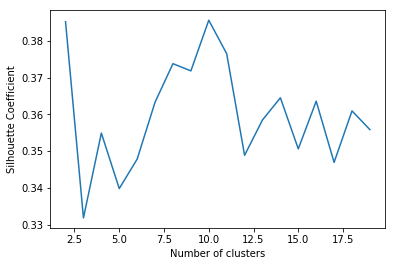

In [50]:
k_range = range(2,20)
scores = []
for k in k_range:
    print(k)
    km_ss = KMeans(n_clusters=k, random_state=19)
    km_ss.fit(features_scaled)
    scores.append(silhouette_score(features_scaled, km_ss.labels_))

print(scores)

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [51]:
km10 = KMeans(n_clusters=10,random_state=19)
km10.fit(features_scaled)
score = silhouette_score(features_scaled, km_ss.labels_)
train_orig_upsamples['kmeans_10_scaled'] = [ "cluster_" + str(label) for label in km10.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

0.355830637785091


In [53]:
km2 = KMeans(n_clusters=2,random_state=19)
km2.fit(features_scaled)
score = silhouette_score(features_scaled, km_ss.labels_)
train_orig_upsamples['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

0.355830637785091


In [54]:
train_orig_upsamples.groupby('Annotation')['kmeans_2_scaled'].value_counts()

Annotation  kmeans_2_scaled
bbc         cluster_1          107
high multi  cluster_0           15
            cluster_1           13
high slug   cluster_0           25
            cluster_1           10
low multi   cluster_1           90
            cluster_0            8
low slug    cluster_1          224
            cluster_0          138
rand_noise  cluster_0          472
            cluster_1          158
Name: kmeans_2_scaled, dtype: int64